### Random Forest Model Optimization Report (with SMOTE + Hyperparameter Tuning)

This section documents the full process of optimizing a Random Forest model for binary loan risk classification. The objective was to classify loans as either Low Risk (Grades A/B) or High Risk (Grades C–G).

---

#### 1. Data Preparation
- Converted multi-class loan grade into binary target:
  - `0` = Low Risk (Grades A/B)
  - `1` = High Risk (Grades C–G)
- Performed 80/20 train-test split using `train_test_split`.

---

#### 2. Feature Scaling
- Applied `StandardScaler` to normalize feature values.
- Scaling improves model stability and convergence.

---

#### 3. Class Imbalance Handling with SMOTE
- Applied **SMOTE (Synthetic Minority Oversampling Technique)** only to the training set.
- Balanced the number of samples in each class.
- Significantly improved the model’s recall for minority (high-risk) loans.

---

#### 4. Hyperparameter Tuning with RandomizedSearchCV
 To fine-tune the model, `RandomizedSearchCV` was used to search over a predefined grid of hyperparameters:
- Number of trees (`n_estimators`): 100, 150, 200
- Tree depth (`max_depth`): 10, 20, None
- Minimum samples per split (`min_samples_split`): 2, 5
- Feature selection strategy (`max_features`): 'sqrt', 'log2'

The search was performed using 2-fold cross-validation on the SMOTE-balanced training data.  
The best parameter combination was selected based on validation performance.

---

#### 5. Model Evaluation

**Final Accuracy:** `73.90%`

**Classification Report:**

| Class      | Precision | Recall | F1-score | Support   |
|------------|-----------|--------|----------|-----------|
| Low Risk   | 0.72      | 0.75   | 0.74     | 219,317   |
| High Risk  | 0.76      | 0.73   | 0.74     | 232,817   |

   

|  Accuracy    |                  |   0.74   | 452,134   |
| Macro Avg    | 0.74    | 0.74   | 0.74     | 452,134   |
| Weighted Avg | 0.74    | 0.74   | 0.74     | 452,134   |

 **Insight:**  
The model showed strong and balanced performance. High-risk loans had slightly better precision, while low-risk loans had slightly better recall — indicating good generalization across both classes.

###  Conclusion
This optimized Random Forest model — trained with SMOTE and tuned via RandomizedSearchCV — achieved **robust performance (73.9% accuracy)** with balanced precision and recall. It is production-ready and performs reliably across both loan risk categories.


In [1]:
! pip install psycopg2-binary
# Import dependencies
import pandas as pd # Data manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import psycopg2
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sqlalchemy import create_engine

**Loading and Preprocessing Loans Encoded Data**

In [2]:
# Load credentials
with open("../../db_config.json") as f:
    config = json.load(f)


In [3]:
# Connect to PostgreSQL
conn = psycopg2.connect(
    host=config["host"],
    port=config["port"],
    database=config["database"],
    user=config["user"],
    password=config["password"]
)

# Create SQLAlchemy engine
engine = create_engine(f"postgresql+psycopg2://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}")


In [4]:
df_borrower = pd.read_sql("SELECT * FROM borrower_info;", engine)
df_borrower.head()

,member_id,home_ownership,merged_annual_inc,merged_dti,emp_length_grouped,clean_verification_status,merged_purpose
0,1,RENT,55000.0,18.24,10+ years,Not Verified,Debt-related
1,3,MORTGAGE,59280.0,10.51,4-6 years,Verified,Debt-related
2,5,MORTGAGE,57250.0,26.35,10+ years,Not Verified,Debt-related
3,6,MORTGAGE,152500.0,37.94,10+ years,Not Verified,Debt-related
4,9,MORTGAGE,53580.0,21.16,10+ years,Verified,Debt-related


In [5]:
df_loan = pd.read_sql("SELECT * FROM loan_info;", engine)
df_loan.head()

,loan_id,member_id,funded_amnt,term,int_rate,grade,loan_status
0,loan1,1,2500,36 months,13.56,C,Current
1,loan2,2,30000,60 months,18.94,D,Current
2,loan3,3,5000,36 months,17.97,D,Current
3,loan4,4,4000,36 months,18.94,D,Current
4,loan5,5,30000,60 months,16.14,C,Current


In [6]:
df_credit_history = pd.read_sql("SELECT * FROM credit_history;", engine)
df_credit_history.head()

,loan_id,all_util,avg_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit
0,loan1,28.0,1878.0,60124.0,34.0,16901.0,36500.0
1,loan2,57.0,24763.0,372872.0,44.0,99468.0,15000.0
2,loan3,35.0,18383.0,136927.0,13.0,11749.0,13800.0
3,loan4,70.0,30505.0,385183.0,13.0,36151.0,5000.0
4,loan5,54.0,9667.0,157548.0,26.0,29674.0,9300.0


In [7]:
df_delinquency = pd.read_sql("SELECT * FROM delinquency_info;", engine)
df_delinquency.head()

,loan_id,delinq_amnt,delinq_bucket,acc_now_delinq_bucketed,delinq_2yrs_bucketed,accounts_90d_past_due_24m,total_chargeoffs_within_12_mths,pub_rec_bankruptcies_bucketed,percent_bc_gt_75_bucketed,pct_tl_nvr_dlq_bucketed,open_acc_bucketed
0,loan1,0.0,Unknown,No Delinquencies,0,0,0,1,0,100.0,6-10
1,loan2,0.0,Unknown,No Delinquencies,0,0,0,0,50.1-75%,100.0,6-10
2,loan3,0.0,61+ months,No Delinquencies,0,0,0,1,0,90-99.9,11-15
3,loan4,0.0,Unknown,No Delinquencies,0,0,0,0,0,100.0,11-15
4,loan5,0.0,Unknown,No Delinquencies,0,0,0,0,0,100.0,6-10


In [9]:
# Merge borrower_info on member_id
df_merged = df_loan.merge(df_borrower, on="member_id", how="left")

# Merge credit_history on loan_id
df_merged = df_merged.merge(df_credit_history, on="loan_id", how="left")

# Merge delinquency_info on loan_id
df_loans_post= df_merged.merge(df_delinquency, on="loan_id", how="left")

# Show final dataset
df_loans_post.head()

,loan_id,member_id,funded_amnt,term,int_rate,grade,loan_status,home_ownership,merged_annual_inc,merged_dti,...,delinq_amnt,delinq_bucket,acc_now_delinq_bucketed,delinq_2yrs_bucketed,accounts_90d_past_due_24m,total_chargeoffs_within_12_mths,pub_rec_bankruptcies_bucketed,percent_bc_gt_75_bucketed,pct_tl_nvr_dlq_bucketed,open_acc_bucketed
0,loan1,1,2500,36 months,13.56,C,Current,RENT,55000.0,18.24,...,0.0,Unknown,No Delinquencies,0,0,0,1,0,100.0,6-10
1,loan2,2,30000,60 months,18.94,D,Current,MORTGAGE,90000.0,26.52,...,0.0,Unknown,No Delinquencies,0,0,0,0,50.1-75%,100.0,6-10
2,loan3,3,5000,36 months,17.97,D,Current,MORTGAGE,59280.0,10.51,...,0.0,61+ months,No Delinquencies,0,0,0,1,0,90-99.9,11-15
3,loan4,4,4000,36 months,18.94,D,Current,MORTGAGE,92000.0,16.74,...,0.0,Unknown,No Delinquencies,0,0,0,0,0,100.0,11-15
4,loan5,5,30000,60 months,16.14,C,Current,MORTGAGE,57250.0,26.35,...,0.0,Unknown,No Delinquencies,0,0,0,0,0,100.0,6-10


In [10]:
# Rename dataframe
df_loans = df_loans_post.copy()

In [11]:

df_loans = df_loans[['member_id', 'funded_amnt', 'term', 'int_rate', 'grade',
       'loan_status', 'home_ownership', 'merged_annual_inc', 'merged_dti',
       'emp_length_grouped', 'clean_verification_status', 'merged_purpose',
       'all_util', 'avg_cur_bal', 'tot_hi_cred_lim', 'total_acc',
       'total_bal_ex_mort', 'total_bc_limit', 'delinq_amnt', 'delinq_bucket',
       'acc_now_delinq_bucketed', 'delinq_2yrs_bucketed',
       'accounts_90d_past_due_24m', 'total_chargeoffs_within_12_mths',
       'pub_rec_bankruptcies_bucketed', 'percent_bc_gt_75_bucketed',
       'pct_tl_nvr_dlq_bucketed', 'open_acc_bucketed']]

In [12]:
# desribe the dataset
df_loans.describe()

,member_id,funded_amnt,int_rate,merged_annual_inc,merged_dti,all_util,avg_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,delinq_amnt,delinq_2yrs_bucketed,accounts_90d_past_due_24m,total_chargeoffs_within_12_mths,pub_rec_bankruptcies_bucketed
count,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.260668e+06,1.394320e+06,2.190322e+06,2.190392e+06,2.260639e+06,2.210638e+06,2.210638e+06,2.260639e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06
mean,1.130334e+06,1.504166e+04,1.309291e+01,8.138379e+04,1.815503e+01,5.703230e+01,1.354780e+04,1.782428e+05,2.416255e+01,5.102294e+04,2.319377e+04,1.236983e+01,2.875526e-01,8.298786e-02,8.950009e-03,1.208868e-01
std,6.525988e+05,9.188413e+03,4.832114e+00,1.137092e+05,8.398329e+00,2.090475e+01,1.647408e+04,1.815748e+05,1.198753e+01,4.991124e+04,2.300656e+04,7.264648e+02,7.149279e-01,2.758639e-01,9.490542e-02,3.259958e-01
min,1.000000e+00,5.000000e+02,5.310000e+00,1.896000e+03,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.651678e+05,8.000000e+03,9.490000e+00,4.800000e+04,1.187000e+01,4.300000e+01,3.080000e+03,5.073100e+04,1.500000e+01,2.089200e+04,8.300000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.130334e+06,1.287500e+04,1.262000e+01,6.850000e+04,1.767000e+01,5.800000e+01,7.335000e+03,1.142985e+05,2.200000e+01,3.786400e+04,1.630000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.695501e+06,2.000000e+04,1.599000e+01,9.800000e+04,2.407000e+01,7.200000e+01,1.878300e+04,2.577550e+05,3.100000e+01,6.435000e+04,3.030000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.260668e+06,4.000000e+04,3.099000e+01,1.100000e+08,6.949000e+01,2.390000e+02,9.580840e+05,9.999999e+06,1.760000e+02,3.408095e+06,1.569000e+06,2.499250e+05,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00


In [13]:
# Add a new column 'is_high_risk' based on the 'grade' column
df_loans['is_high_risk'] = df_loans['grade'].apply(lambda x: 1 if x in ['C','D', 'E', 'F', 'G'] else 0)

In [14]:
# Define the feature set
X = df_loans.drop(columns=['is_high_risk','int_rate', 'grade'])

# Define the target
y = df_loans['is_high_risk']

# Encode the categorical variables using get_dummies
X = pd.get_dummies(X)

# Review the feature data
X.head()

,member_id,funded_amnt,merged_annual_inc,merged_dti,all_util,avg_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,...,pct_tl_nvr_dlq_bucketed_90-99.9,pct_tl_nvr_dlq_bucketed_<80,pct_tl_nvr_dlq_bucketed_Unknown,open_acc_bucketed_0,open_acc_bucketed_1-5,open_acc_bucketed_11-15,open_acc_bucketed_16-20,open_acc_bucketed_21+,open_acc_bucketed_6-10,open_acc_bucketed_Unknown
0,1,2500,55000.0,18.24,28.0,1878.0,60124.0,34.0,16901.0,36500.0,...,False,False,False,False,False,False,False,False,True,False
1,2,30000,90000.0,26.52,57.0,24763.0,372872.0,44.0,99468.0,15000.0,...,False,False,False,False,False,False,False,False,True,False
2,3,5000,59280.0,10.51,35.0,18383.0,136927.0,13.0,11749.0,13800.0,...,True,False,False,False,False,True,False,False,False,False
3,4,4000,92000.0,16.74,70.0,30505.0,385183.0,13.0,36151.0,5000.0,...,False,False,False,False,False,True,False,False,False,False
4,5,30000,57250.0,26.35,54.0,9667.0,157548.0,26.0,29674.0,9300.0,...,False,False,False,False,False,False,False,False,True,False


In [15]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 29 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   member_id                        int64  
 1   funded_amnt                      int64  
 2   term                             object 
 3   int_rate                         float64
 4   grade                            object 
 5   loan_status                      object 
 6   home_ownership                   object 
 7   merged_annual_inc                float64
 8   merged_dti                       float64
 9   emp_length_grouped               object 
 10  clean_verification_status        object 
 11  merged_purpose                   object 
 12  all_util                         float64
 13  avg_cur_bal                      float64
 14  tot_hi_cred_lim                  float64
 15  total_acc                        float64
 16  total_bal_ex_mort                float64
 17  total_bc

In [16]:
# Seprate the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
from sklearn.impute import SimpleImputer
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

In [18]:
#  Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

In [19]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

c:\Users\seyhr\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [20]:
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=5,         # Number of random combinations to try
    cv=2,             # 2-fold cross-validation
    n_jobs=-1,        # Use all CPU cores
    verbose=2,
    random_state=42
)


In [21]:
random_search.fit(X_train_bal, y_train_bal)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


c:\Users\seyhr\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\seyhr\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\seyhr\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\seyhr\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_forest.py", line 487, in fit
    trees = Parallel(
  File "c:\User

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 150, 200]},
                   random_state=42, verbose=2)

In [22]:
# Get best model
best_model = random_search.best_estimator_
print("Best Parameters Found:", random_search.best_params_)

Best Parameters Found: {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': None}


In [23]:
# Evaluate on test data
y_pred = best_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"\nRandom Forest Tuned Model Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Low Risk", "High Risk"]))


Random Forest Tuned Model Accuracy: 0.7390
Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.72      0.75      0.74    219317
   High Risk       0.76      0.73      0.74    232817

    accuracy                           0.74    452134
   macro avg       0.74      0.74      0.74    452134
weighted avg       0.74      0.74      0.74    452134



In [26]:
# Save model + features
joblib.dump(best_model, "../../models/rf_model_tuned.pkl")
joblib.dump(list(X.columns), "../../models/rf_model_features_tunned.pkl")

['../../models/rf_model_features_tunned.pkl']

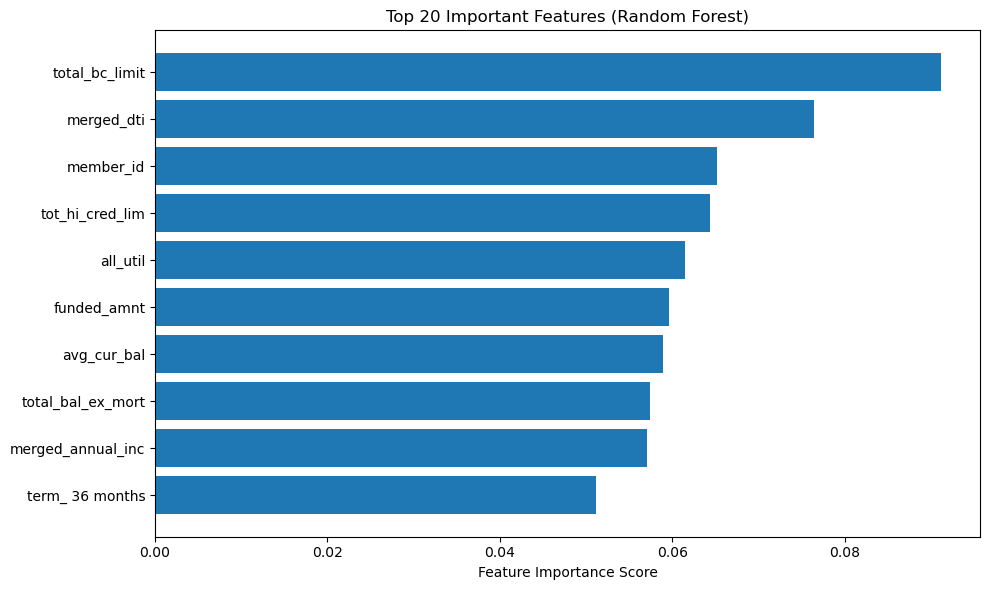

In [25]:
# Get feature importances from the best model
importances = best_model.feature_importances_
feature_names = X.columns  # or X_train.columns if you used a split

# Create a DataFrame for easy sorting/plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:10][::-1], feat_imp_df['Importance'][:10][::-1])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Important Features (Random Forest)')
plt.tight_layout()
plt.show()
